In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt

TUTORIAL_DIR = Path(os.getcwd()).as_posix()

# Energytool Building

The aim of the tutorial is to introduce the energytool <code>Building</code> class.
It is build on top of [energyplus](https://energyplus.net/) and of the python library [eppy](https://github.com/santoshphilip/eppy).
It has been designed to simplify the HVAC, Domestic Hot Water (DHW) production and local energy production (Photovoltaic)

<img src="resources/building_class.png"  height="300">

- It has only one positional argument "idf_path". When instantiated it uses eppy.modeleditor <code>IDF</code> to read the idf file
- 7 <code>dict</code> are used to organise the HVAC DHW and production equipments objects. Additional objects can be stored in the "other" <code>dict</code>, such as thermal comfort indicator objects.

- <code>property</code> are defined to compute specific results.

During simulation :

1- The <code>pre_process()</code> method is called. It calls the <code>pre_process()</code> method of each object contained in the previously described <code>dict</code>. Be careful, order matters in some cases

2- Energyplus is called and the simulation runs.

3- The <code>post_process()</code> method is called. It calls the <code>post_process()</code> method of each object contained in the previously described <code>dict</code>.

## 1- Instantiate a Building

Let's load an example idf file that model a 2 storey and 4 apartments building:

|             Figure 1: Building model perspective              |                 Figure 2: Building first floor                  |
|:-------------------------------------------------------------:|:---------------------------------------------------------------:|
| <img height="300" src="resources/building_tuto_3d_pers.png"/> | <img src="resources/building_tuto_1st_floor.png"  height="300"> |

In [2]:
from energytool.building import Building

In [3]:
building = Building(idf_path=Path(TUTORIAL_DIR) / "resources/tuto_building.idf")

<code>Building</code> method <code>infos()</code> displays information on the model

In [4]:
building.infos()

==Building==

Number of occupants : 3.8
Building surface : 176.89350000000002 m²
Building volume : 521.6447000000001 m3
Zone number : 5

==HVAC systems==

Heating systems : []
Cooling systems : []
Ventilation system : []
Artificial lighting system : []
DHW production : []
PV production : []
Others : []


Building surface, zone number, etc. are calculated from the imported idf file.
In the HVAC section we can see that the 7 dictionaries are empty.

However, it doesn't mean that no HVAC system are  modeled in the idf file.
 - Heating and ventilation are modeled using IdealLoadsAirSystem
 - Artificial Lighting is defined with the object Lights

__*The <code>Building</code> class allows you to add "Systems" that will edit a part of the  idf file and/or select and apply a post treatment to the simulation results. It cannot replace proper idf HVAC configuration. The use of IdealLoadsAirSystem is recommended.*__


## 2- Add systems

In energytool, a system is a class that modify an idf file or post process results.
The module <code>energytool.system</code> holds several examples of system class.
Custom class can be written as long as they have the following structure :

<img src="resources/system_class.png"  height="300">

- The attribute <code>building</code> is the only mandatory attribute. It references the building object where the system will be connected
- The other attributes depends on the system (COP, list of zone names, etc.)
- Every system have a <code>pre-process()</code> and a <code>post-process()</code> methods


In the following lines we add most of the systems present in <code>energytool.system</code> module.
 For more information on the effects of each system on the simulation, see the <code>energytool.system</code> documentation.

In [5]:
from energytool.system import HeaterSimple
from energytool.system import AuxiliarySimplified
from energytool.system import AirHandlingUnit
from energytool.system import AHUControl
from energytool.system import DHWIdealExternal
from energytool.system import ArtificialLightingSimple

In [6]:
# Simulate a boiler, multiplying the heat needs by a constant COP
building.heating_system["Main_boiler"] = HeaterSimple(
    name="Gaz_boiler",
    building=building,
    cop=0.89
)

# Estimate circulation pumps energy consumption multiplying the heat needs by a constant (default 0.05)
building.heating_system["Circulation_pumps"] = AuxiliarySimplified(
    name="Heater_aux",
    building=building
)

# Simulate fan consumption multiplying extracted air volume by a constant coefficient
# Do not have a heat exchanger
building.ventilation_system["Main_AHU"] = AirHandlingUnit(
    name="Extraction_fan",
    building=building,
    fan_energy_coefficient=0.23, # Wh/m3
    heat_recovery_efficiency=False
)

# Simulate clock regulation
# Ventilation works according to specified schedule
#  is defined in the energytool/resources/resources_idf.idf file
building.ventilation_system["AHU_control"] = AHUControl(
    name="Hygro_intakes",
    building=building,
    control_strategy="Schedule",
    schedule_name="OFF_09h_18h_ON_18h_24h_ON_WE_FULL_YEAR",
)

# Estimate Domestic Hot Water production energy needs
# Use the number of people defined in the idf file to estimate the total volume.
# Otherwise, energy calculation is independent of energyplus
building.dwh_system["DHW_production"] = DHWIdealExternal(
    name="Electric_accumulation",
    building=building,
    cop=0.85,
)

# Estimate Domestic Hot Water production energy needs
# Use the number of people defined in the idf file to estimate the total volume.
# Otherwise, energy calculation is independent of energyplus
building.dwh_system["DHW_production"] = DHWIdealExternal(
    name="Electric_accumulation",
    building=building,
    cop=0.85,
)

# Estimate Lighting consumption using a constant power ratio.
# Modify the existing energyplus object
building.artificial_lighting_system["Lights"] = ArtificialLightingSimple(
    name="Random_lights",
    building=building,
    power_ratio=4 # W/m²
)

## 3- Thermal comfort and other post treatment

For now, occupant thermal comfort is a property of <code>Building</code>. It is often computed from several simulation outputs. They need to be specified 'a-priori'. The <code>Building</code> dictionary <code>other</code> is designed to hold the objects that don't belong to HVAC systems but that will apply pre- or post-process methods.

In this example, we use the French HQE definition of occupant thermal comfort. Thus we need to obtain the Zones Operative Temperature and the occupancy schedule for each zone.

In [7]:
from energytool.indicators import AddOutputVariables

In [8]:
building.other["Thermal_comfort_variables"] = AddOutputVariables(
    name="HQE_discomfort",
    building=building,
    variables=["Zone Operative Temperature", "Zone People Occupant Count"]
)

Using <code>infos</code> you can check the systems you just added

In [9]:
building.infos()

==Building==

Number of occupants : 3.8
Building surface : 176.89350000000002 m²
Building volume : 521.6447000000001 m3
Zone number : 5

==HVAC systems==

Heating systems : ['Main_boiler', 'Circulation_pumps']
Cooling systems : []
Ventilation system : ['Main_AHU', 'AHU_control']
Artificial lighting system : ['Lights']
DHW production : ['DHW_production']
PV production : []
Others : ['Thermal_comfort_variables']


## 4. Building simulation

### 4.1 Single simulation

Energytool is designed to execute batch of several simulations in parallel. Therefore two <code>class</code> of the <code>energytool.simulate</code> are used:
- <code>Simulation</code> is used to define the simulation parameters and weather file
- <code>SimulationRunner</code> is used to run a <code>list</code> of <code>Simulation</code>

In [10]:
from energytool.simulate import Simulation
from energytool.simulate import SimulationsRunner

In [11]:
import datetime as dt

In [12]:
# Define a simulation
my_simulation = Simulation(
    building=building,
    epw_file_path=Path(TUTORIAL_DIR) / "resources/FRA_Bordeaux.075100_IWEC.epw",
    simulation_start=dt.datetime(2022, 1, 1, 0, 0, 0),
    simulation_stop=dt.datetime(2022, 12, 31, 23, 0, 0),
    timestep_per_hour=1,
)

Energyplus doesn't care about the year. But it can be useful if you are calibrating a simulation, or if you need the right day of week (monda, tuesday, etc.). That's why the notion of "year" have been added to energytool. If you don't need it, you can leave <code>simulation_start</code> and <code>simulation_stop</code> to default. It will run the simulation for a full year.

In [13]:
# Define a runner with a list of 1 simulation
simulation_runner = SimulationsRunner(simu_list=[my_simulation])

In [14]:
# Run it !!!
simulation_runner.run()

Simulation results are available at building level. They are stored in a <code>DataFrame</code> at an hourly timestep :
 - <code>energyplus_results</code> contains raw energyplus results
 - <code>building_results</code> contains HVAC objects post treated results
 - <code>system_energy_results</code> property contains RT 2020 type results

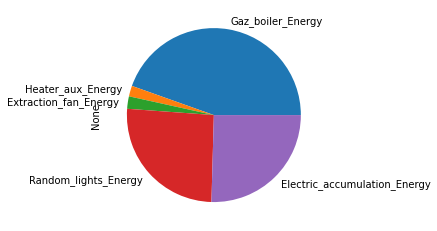

In [15]:
# At building level
building.building_results.sum().plot(kind="pie")
plt.show()

### 4.2 Building modifications and batch simulation

The aim af energytool is to make batch simulation building in order to quickly simulate and compare building variant.
To make a building variant, you have to make a <code>deepcopy()</code> of your building, and pass it to a new <code>Simulation</code> object

In the following example, we will make to variants.
1- Changing the Main boiler COP to 2.5
2- changing the lights power ratio to 2W/m²

In [16]:
from copy import deepcopy

In [17]:
variant_1 = deepcopy(building)
variant_1.heating_system["Main_boiler"].cop = 2

In [18]:
variant_2 = deepcopy(building)
variant_2.artificial_lighting_system["Lights"].power_ratio = 2

In [19]:
simu_var_1 = Simulation(
    building=variant_1,
    epw_file_path=Path(TUTORIAL_DIR) / "resources/FRA_Bordeaux.075100_IWEC.epw")

simu_var_2 = Simulation(
    building=variant_2,
    epw_file_path=Path(TUTORIAL_DIR) / "resources/FRA_Bordeaux.075100_IWEC.epw")

The new simulations can be passed to a <code>SimulationRunner</code>.
Following arguments can be passed :
- <code>run_dir</code> provide a <code>Path</code> object to specify the folder where the simulations will be executed. By default, energytool creates a temporary folder. The argument is useful mainly for debug purpose
- <code>nb_cpus</code> specify the number of CPUs you want energytool to use. Default is -1 meaning all the CPUs available
- <code>nb_simu_per_batch</code> default is 10. We recommend that this number is superior or equal to the number of CPUs

In [20]:
runner = SimulationsRunner(
    simu_list=[simu_var_1, simu_var_2])
runner.run()

After some Pandas and matplolib manipulation, you can easily compare the results

In [21]:
import pandas as pd

In [22]:
combine_df = pd.concat(
    [var.building_results.sum()
     for var in [building, variant_1, variant_2]],
    axis=1)
combine_df.columns = ["Existing", "variant_1", "variant_2"]
combine_df = combine_df / 3600 / 1000

Text(0, 0.5, 'Building consumption [kWh]')

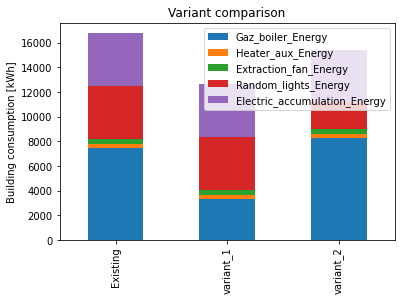

In [23]:
combine_df.T.plot(kind="bar", stacked=True)
plt.title("Variant comparison")
plt.ylabel("Building consumption [kWh]")

In [25]:
building.overshoot_thermal_comfort

BLOCK1:APPTX1E     48.644986
BLOCK1:APPTX1E1    50.271003
BLOCK1:APPTX1W     51.016260
BLOCK2:APPTX2E     51.693767
BLOCK2:APPTX2W     52.506775
dtype: float64